In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from collections import defaultdict

from IPython.display import HTML
from IPython.display import display_html

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
from utils.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
CLUSTERS = ["cosmos08", "cosmos09", "cosmos14", "cosmos15"]
#CLUSTERS = ["cosmos08", "cosmos09", "cosmos14"]
#CLUSTERS = ["cosmos09", "cosmos15"]

FN_TMP = "../data/{CLUSTER}/op_df.csv"
FN_TMP2 = "../data/{CLUSTER}/expr_df.csv"
#DEDUPFN = FN.replace(".ss.csv", "-dedup.ss.csv")
#AUGMENTED_FN = FN.replace(".ss.csv", "-augmented.ss.csv")

INP_FIELD = "NormInputHashCode"
FILTER_FIELD = "FilterExpr"

#WKS = ["job", "tpcds", "tpch", "stack"]
WKS = ["job", "tpcds1", "tpch1", "stack", "ceb"]

WORKLOADS = {}
WORKLOADS["stack"] = "../data/stack/dfs"
WORKLOADS["tpcds"] = "../data/tpcds/all/dfs/"
WORKLOADS["tpcds1"] = "../data/tpcds1/all/dfs/"
WORKLOADS["job"] = "../data/job/all_job/sqls/dfs/"
WORKLOADS["tpch"] = "../data/tpch/all/dfs"
WORKLOADS["tpch1"] = "../data/tpch1/all/dfs"
WORKLOADS["ceb"] = "../data/ceb-all/sqls/dfs/"

EXPRDF_FIELDS0 = ['jobid', INP_FIELD, 'unique_filter_cols',
       'discrete_ops', 'cont_ops', 'like_ops', 'num_unique_ops', 'num_ops',
       'num_discrete_consts', 'num_likes', 'like_lens', 
        #'workload', 
        'db', 'cluster', 'StageName',
        'InputCardinality', 'RowCount', 'Selectivity']

EXPRDF_FIELDS = ['jobid', 'input', 'unique_filter_cols',
       'discrete_ops', 'cont_ops', 'like_ops', 'num_unique_ops', 'num_ops',
       'num_discrete_consts', 'num_likes', 'like_lens', 
        'workload', 
        'db', 'cluster', "StageName",
        'InputCardinality', 'RowCount', 'Selectivity']

OPDF_FIELDS0 = ['op', 'dtype', 'optype', 'constant', 'input', 'column', 'opstring',
       'jobid', 'exprhash', 'StageName',
       #'workload', 
        'db', 'cluster']

OPDF_FIELDS = ['op', 'dtype', 'optype', 'constant', 'input', 'column', 'opstring',
       'jobid', 'exprhash', 'StageName',
       'workload', 'cluster',
        'db']

#DSCOLORS = ["blue", "red", "green", "black"]
DSCOLORS = {}
DSCOLORS["tpcds"] = "red"
DSCOLORS["tpcds1"] = "red"
DSCOLORS["tpch"] = "purple"
DSCOLORS["tpch1"] = "purple"

DSCOLORS["job"] = "green"
DSCOLORS["ceb"] = "orange"
DSCOLORS["stack"] = "blue"
DSCOLORS["cosmos"] = "grey"

In [192]:
wk_opdfs = []
wk_exprdfs = []

for wk in WKS:
    dirname = WORKLOADS[wk]
    opfn = os.path.join(dirname, "op_df.csv")
    exprfn = os.path.join(dirname, "expr_df.csv")
    wk_opdfs.append(pd.read_csv(opfn))
    wk_exprdfs.append(pd.read_csv(exprfn))

In [193]:
wopdf = pd.concat(wk_opdfs)
wedf = pd.concat(wk_exprdfs)

In [194]:
wopdf["cluster"] = wopdf["db"]
wopdf["StageName"] = "SV1_"
wopdf = wopdf[OPDF_FIELDS]

In [195]:
wedf["cluster"] = wedf["db"]
wedf["StageName"] = "SV1_"
wedf = wedf[EXPRDF_FIELDS]

In [196]:
print(set(wedf["workload"]))

{'job', 'stack', 'tpcds1', 'tpch1', 'ceb'}


In [197]:
#set(wedf["RowCount"])

In [198]:
opdfs = []
exprdfs = []

for cluster in CLUSTERS:
    print(cluster)
    fn = FN_TMP.format(CLUSTER=cluster)
    opdfs.append(pd.read_csv(fn, usecols = OPDF_FIELDS0))
    
    fn2 = FN_TMP2.format(CLUSTER=cluster)
    exprdfs.append(pd.read_csv(fn2, usecols = EXPRDF_FIELDS0))

cosmos08


/home/pari/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


cosmos09
cosmos14
cosmos15


In [199]:
opdf = pd.concat(opdfs)
exprdf = pd.concat(exprdfs)

In [200]:
print(set(exprdf["cluster"]))

{'cosmos14', 'cosmos08', 'cosmos09', 'cosmos15'}


In [201]:
#exprdf.groupby("cluster")["Selectivity"].describe(percentiles=[0.25,0.75, 0.90, 0.95, 0.99])

In [202]:
exprdf["workload"] = "cosmos"
exprdf = exprdf.rename(columns={INP_FIELD:"input"})
exprdf = exprdf[EXPRDF_FIELDS]

In [203]:
print(len(set(exprdf["input"])))
print(len(set(exprdf["db"])))

66169
45635


In [204]:
exprdf = pd.concat([exprdf, wedf], ignore_index=True)

In [205]:
exprdf["Stage1"] = exprdf.apply(lambda x: "SV1_" in str(x["StageName"]) ,axis=1)
exprdf1 = exprdf[exprdf["Stage1"] == True]

In [206]:
print(len(set(exprdf1["input"])))
print(len(set(exprdf1["db"])))

18569
16032


In [207]:
opdf["workload"] = "cosmos"
opdf["Stage1"] = opdf.apply(lambda x: "SV1_" in str(x["StageName"]) ,axis=1)
opdf1 = opdf[opdf["Stage1"] == True]
opdf = opdf[OPDF_FIELDS]
opdf1 = opdf1[OPDF_FIELDS]

In [208]:
opdf = pd.concat([opdf, wopdf])

In [209]:
opdf1 = pd.concat([opdf1, wopdf])

In [210]:
print(len(opdf), len(exprdf))

35102647 7811550


In [211]:
pd.options.display.max_colwidth = 1000
pd.set_option('display.max_columns', 100)

In [212]:
opdf.head(5)

,op,dtype,optype,constant,input,column,opstring,jobid,exprhash,StageName,workload,cluster,db
0,=,bool,=,false,-915329154,-915329154IsFraud:,=,57e6ae0e-75b4-5289-b4ab-b8b622a56e51,5064756342040975012009299131817552574291618420,SV1_Extract_Partition,cosmos,cosmos08,cosmos08-4103124
1,=,num,=,0,-915329154,-915329154DupAdId:,=,57e6ae0e-75b4-5289-b4ab-b8b622a56e51,5064756342040975012009299131817552574291618420,SV1_Extract_Partition,cosmos,cosmos08,cosmos08-4103124
2,=,num,=,5,-915329154,-915329154AdDisplayTypeId:,=,57e6ae0e-75b4-5289-b4ab-b8b622a56e51,5064756342040975012009299131817552574291618420,SV1_Extract_Partition,cosmos,cosmos08,cosmos08-4103124
3,=,num,=,3,-915329154,-915329154DomainType:,=,57e6ae0e-75b4-5289-b4ab-b8b622a56e51,5064756342040975012009299131817552574291618420,SV1_Extract_Partition,cosmos,cosmos08,cosmos08-4103124
4,!=,num,!=,11,-915329154,-915329154CampaignSubTypeId:,!=,57e6ae0e-75b4-5289-b4ab-b8b622a56e51,5064756342040975012009299131817552574291618420,SV1_Extract_Partition,cosmos,cosmos08,cosmos08-4103124


# Discrete vs Continuous etc

In [213]:
dbcounts = exprdf.groupby("db").count()["jobid"].reset_index().sort_values(by="jobid", ascending=False)
#dbcounts["jobid"].describe(percentiles=[0.9,0.99])
dbcounts1 = exprdf1.groupby("db").count()["jobid"].reset_index().sort_values(by="jobid", ascending=False)
dbcounts["jobid"].describe(percentiles=[0.9,0.99])

count    4.564000e+04
mean     1.711558e+02
std      1.157320e+04
min      1.000000e+00
50%      2.000000e+00
90%      1.600000e+01
99%      6.126100e+02
max      2.035301e+06
Name: jobid, dtype: float64

In [214]:
dbinpcounts = exprdf.groupby("db")["input"].nunique().reset_index().sort_values(by="input", ascending=False)
#dbinpcounts.head(100)

In [215]:
seldbs = dbcounts[dbcounts["jobid"] >= 10]["db"].values
seldbs = list(seldbs) + WKS

seldbs1 = dbcounts1[dbcounts1["jobid"] >= 10]["db"].values
seldbs1 = list(seldbs1) + WKS

# seldbs1 = dbinpcounts[dbinpcounts["input"] >= 10]["db"].values
# seldbs1 = list(seldbs1) + WKS

dbmeans = exprdf.groupby(["db", "cluster", "workload"])[["cont_ops", "discrete_ops", "like_ops"]].mean().reset_index()
dbmeans = dbmeans[dbmeans.db.isin(seldbs)]

dbmeans1 = exprdf1.groupby(["db", "cluster", "workload"])[["cont_ops", "discrete_ops", "like_ops"]].mean().reset_index()
dbmeans1 = dbmeans[dbmeans.db.isin(seldbs1)]

In [216]:
print(len(seldbs1))

1014


In [223]:
tmp = exprdf1[exprdf1.db.isin(seldbs1)]
print(len(set(tmp["input"])))
print(len(set(tmp["db"])))
print(len(tmp))

2956
1009
173745


/home/pari/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


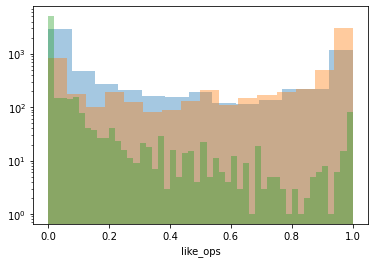

In [224]:
sns.distplot(dbmeans["cont_ops"], kde=False)
sns.distplot(dbmeans["discrete_ops"], kde=False)
sns.distplot(dbmeans["like_ops"], kde=False)
plt.yscale("log")

In [225]:
wedf.groupby("workload")[["cont_ops", "discrete_ops", "like_ops"]].mean()

,cont_ops,discrete_ops,like_ops
workload,,,
ceb,0.145946,0.786426,0.072302
job,0.128763,0.722408,0.204013
stack,0.371122,0.608536,0.105979
tpcds1,0.400000,0.703571,0.003571
tpch1,0.461538,0.564103,0.076923


/home/pari/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


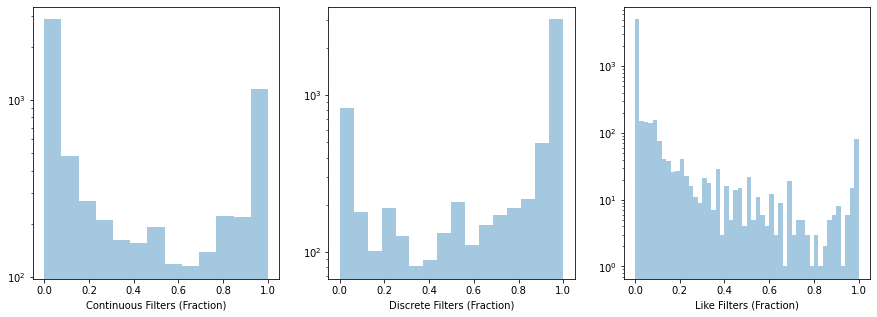

In [226]:
fig,axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax = axs[0]
sns.distplot(dbmeans["cont_ops"], kde=False, ax=ax)
ax.set_yscale("log")
ax.set_xlabel("Continuous Filters (Fraction)")

ax = axs[1]
sns.distplot(dbmeans["discrete_ops"], kde=False, ax=ax)
ax.set_yscale("log")
ax.set_xlabel("Discrete Filters (Fraction)")

ax = axs[2]
sns.distplot(dbmeans["like_ops"], kde=False)
ax.set_yscale("log")
ax.set_xlabel("Like Filters (Fraction)")

plt.savefig("Filter-Type-Distributions.png")

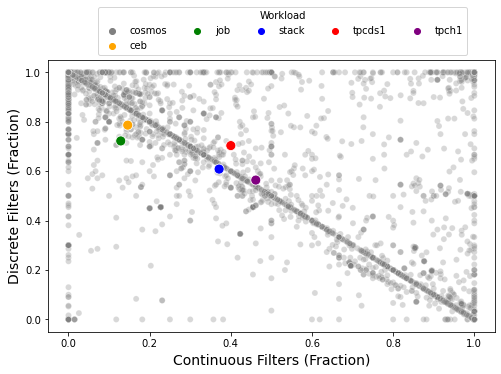

In [227]:
means1 = dbmeans[dbmeans.workload == "cosmos"]
means2 = dbmeans[dbmeans.workload != "cosmos"]
fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(8,5))

sns.scatterplot(data=means1, x="cont_ops", y="discrete_ops", alpha=0.3, hue="workload", palette=["grey"])
sns.scatterplot(data=means2, x="cont_ops", y="discrete_ops", alpha=1.0, hue="workload", s=100, palette=DSCOLORS)

ax.legend(title="Workload", bbox_to_anchor=(0.1, 1.00), ncol=5,
         frameon = True, fontsize=10)
ax.set_ylabel("Discrete Filters (Fraction)", fontsize=14)
ax.set_xlabel("Continuous Filters (Fraction)", fontsize=14)

plt.savefig("Discrete-Continuous.png", dpi=200)
plt.show()

/tmp/ipykernel_3449667/2116888413.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  means1 = dbmeans1[dbmeans.workload == "cosmos"]
/tmp/ipykernel_3449667/2116888413.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  means2 = dbmeans1[dbmeans.workload != "cosmos"]


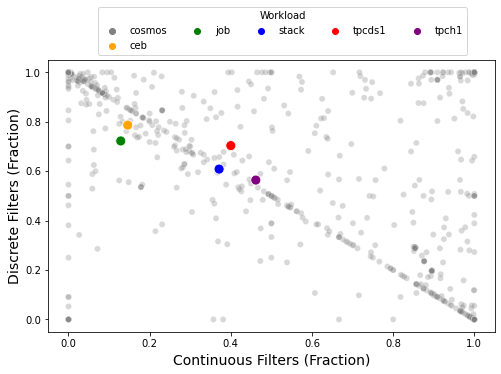

In [228]:
means1 = dbmeans1[dbmeans.workload == "cosmos"]
means2 = dbmeans1[dbmeans.workload != "cosmos"]
fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(8,5))

sns.scatterplot(data=means1, x="cont_ops", y="discrete_ops", alpha=0.3, hue="workload", palette=["grey"])
sns.scatterplot(data=means2, x="cont_ops", y="discrete_ops", alpha=1.0, hue="workload", s=100, palette=DSCOLORS)

ax.legend(title="Workload", bbox_to_anchor=(0.1, 1.00), ncol=5,
         frameon = True, fontsize=10)
ax.set_ylabel("Discrete Filters (Fraction)", fontsize=14)
ax.set_xlabel("Continuous Filters (Fraction)", fontsize=14)

plt.savefig("Discrete-Continuous.png", dpi=200)
plt.show()

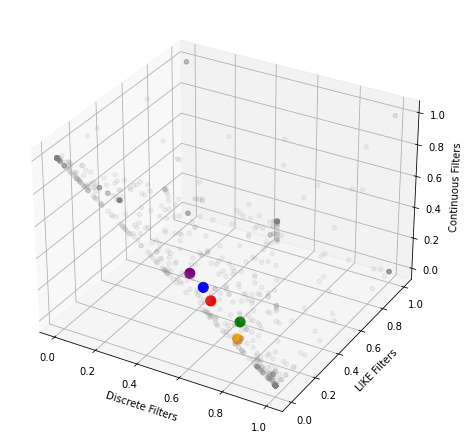

In [229]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap


x = means1["discrete_ops"]
y = means1["like_ops"]
z = means1["cont_ops"]

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# plot
sc = ax.scatter(x, y, z, s=20, marker='o', color="grey", alpha=0.1)

x2 = means2["discrete_ops"]
y2 = means2["like_ops"]
z2 = means2["cont_ops"]

cols = []
for db in means2["db"].values:
    cols.append(DSCOLORS[db])

sc = ax.scatter(x2, y2, z2, s=100, marker='o', color=cols, alpha=1.0)

#for wk in set(means2["workload"]):

ax.set_zlabel('Continuous Filters')
ax.set_xlabel('Discrete Filters')
ax.set_ylabel('LIKE Filters')

# legend
#plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
#plt.savefig("scatter_hue", bbox_inches='tight')

plt.savefig("Discrete-Continuous-Like.png", dpi=200)

# Number of discrete constants

In [230]:
opdf = opdf[~opdf.constant.isna()]
opdf1 = opdf1[~opdf1.constant.isna()]

In [231]:
print(set(opdf["cluster"]))

{'cosmos14', 'job', 'stack', 'cosmos09', 'cosmos15', 'tpcds1', 'tpch1', 'cosmos08', 'ceb'}


In [41]:
discdf = opdf[opdf.op.isin(["!=", "="])]
discdf = discdf[~discdf.constant.str.contains("null")]
discdf1 = opdf1[opdf1.op.isin(["!=", "="])]
discdf1 = discdf1[~discdf1.constant.str.contains("null")]

In [42]:
print(len(set(discdf["column"])))
print(len(set(discdf1["column"])))

80766
19497


In [43]:
cdf = discdf.groupby(["column", "db", "workload", "cluster"])["constant"].nunique().reset_index()
cdf1 = discdf1.groupby(["column", "db", "workload", "cluster"])["constant"].nunique().reset_index()

In [44]:
cdf.sort_values(by="constant", ascending=False).head(50)

,column,db,workload,cluster,constant
207374,Id,stack,stack,stack,47192
182247,530496534tenant_id:,cosmos14-2374532,cosmos,cosmos14,9854
101005,1042378059tenant_id:,cosmos14-2374532,cosmos,cosmos14,9820
181942,530496534tenant_id:,cosmos14-19148750,cosmos,cosmos14,8951
100760,1042378059tenant_id:,cosmos14-19148750,cosmos,cosmos14,7978
182572,530496534tenant_id:,cosmos14-292405,cosmos,cosmos14,7365
101291,1042378059tenant_id:,cosmos14-292405,cosmos,cosmos14,6345
181703,530496534tenant_id:,cosmos14-15912462,cosmos,cosmos14,5931
182306,530496534tenant_id:,cosmos14-24648735,cosmos,cosmos14,5914
100568,1042378059tenant_id:,cosmos14-15912462,cosmos,cosmos14,5219


In [45]:
tmp = cdf1[cdf1.workload == "cosmos"]
tmp.sort_values(by="constant", ascending=False).head(50)

,column,db,workload,cluster,constant
11310,1042378059tenant_id:,cosmos14-2374532,cosmos,cosmos14,6970
11259,1042378059tenant_id:,cosmos14-15912462,cosmos,cosmos14,908
11281,1042378059tenant_id:,cosmos14-19148750,cosmos,cosmos14,857
11338,1042378059tenant_id:,cosmos14-292405,cosmos,cosmos14,505
4374,-1810800635Category:,cosmos08-13185143,cosmos,cosmos08,407
13091,1356944550AttributeId:,cosmos08-54169101,cosmos,cosmos08,372
5453,-2054962026Category:,cosmos08-54169101,cosmos,cosmos08,338
9591,-76930251AttributeId:,cosmos08-54169101,cosmos,cosmos08,338
11315,1042378059tenant_id:,cosmos14-24648735,cosmos,cosmos14,315
5469,-2054962026Category:,cosmos08-77157232,cosmos,cosmos08,262


In [46]:
print(len(set(cdf["column"])))

32749


In [47]:
cdf = cdf[cdf.db.isin(seldbs)]
cdf1 = cdf1[cdf1.db.isin(seldbs1)]
print(len(set(cdf["column"])))

32184


In [48]:
cdf.groupby(["cluster"])["constant"].describe(percentiles=[0.9, 0.99])

,count,mean,std,min,50%,90%,99%,max
cluster,,,,,,,,
ceb,13.0,541.615385,907.975820,2.0,68.0,1355.2,2851.20,3054.0
cosmos08,63557.0,2.016615,7.143017,1.0,1.0,3.0,18.00,429.0
cosmos09,37519.0,1.693169,3.817613,1.0,1.0,2.0,13.00,196.0
cosmos14,7316.0,30.066976,299.988458,1.0,1.0,23.0,501.55,9854.0
cosmos15,64905.0,2.617980,12.665245,1.0,1.0,3.0,28.96,1141.0
job,11.0,10.909091,11.878169,2.0,7.0,33.0,33.90,34.0
stack,125.0,434.568000,4227.968183,1.0,2.0,57.2,2757.52,47192.0
tpcds1,62.0,11.161290,51.693990,1.0,2.0,11.9,175.98,409.0
tpch1,17.0,2.647059,3.019544,1.0,1.0,5.8,11.20,12.0


In [49]:
cdf1.groupby(["cluster"])["constant"].describe(percentiles=[0.9, 0.99])

,count,mean,std,min,50%,90%,99%,max
cluster,,,,,,,,
ceb,13.0,541.615385,907.975820,2.0,68.0,1355.2,2851.20,3054.0
cosmos08,5717.0,2.529124,10.655743,1.0,1.0,3.0,24.84,372.0
cosmos09,1266.0,1.562401,1.851304,1.0,1.0,2.0,10.00,26.0
cosmos14,461.0,21.095445,327.705978,1.0,1.0,4.0,70.80,6970.0
cosmos15,4217.0,1.942139,4.499786,1.0,1.0,3.0,12.00,120.0
job,11.0,10.909091,11.878169,2.0,7.0,33.0,33.90,34.0
stack,125.0,434.568000,4227.968183,1.0,2.0,57.2,2757.52,47192.0
tpcds1,62.0,11.161290,51.693990,1.0,2.0,11.9,175.98,409.0
tpch1,17.0,2.647059,3.019544,1.0,1.0,5.8,11.20,12.0


In [50]:
pconsts = cdf.groupby(["db", "workload"])["constant"].describe(percentiles=[0.5, 0.75, 0.9, 0.99, 0.999]).reset_index()
pconsts1 = cdf1.groupby(["db", "workload"])["constant"].describe(percentiles=[0.5, 0.75, 0.9, 0.99, 0.999]).reset_index()

In [232]:
import matplotlib.patches as mpatches

make_dir("distplots")
PFN_TMP = "./distplots/{prefix}{xlabel}.png"

def plot_distribution(df, col, xlabel, xlim=None, prefix=""):
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,5))
    handles = []
    patch = mpatches.Patch(color=DSCOLORS["cosmos"], label="cosmos")
    handles.append(patch)
    
    xlabel = xlabel.replace("%", "p")
    
    dfc = df[df.workload == "cosmos"]
    dfo = df[df.workload != "cosmos"]
    tpcds = df[df.workload == "tpcds1"]
    sns.distplot(dfc[col], kde=False, ax=ax, hist_kws={"histtype": "bar", "linewidth": 4,
                            "alpha": 0.5, "color": "grey"})
    ax.set_yscale("log")
    
    maxval = max(max(dfc[col]), max(tpcds[col]))
    xlim = (min(dfc[col]), maxval)
    
    ax.set_xlim(xlim)
    
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel("Count (DBs)", fontsize=14)

    dfo = dfo[["db", col]]
    
    
    for _,row in dfo.iterrows():
        nc = row[col]
        color = DSCOLORS[row["db"]]
        ax.plot(nc, random.randint(0,3) + 1, 'o', linewidth=20, color=color)
        patch = mpatches.Patch(color=color, label=row["db"])
        handles.append(patch)
        
    ax.legend(handles=handles)

    if len(prefix) != 0:
        prefix = prefix + "-"
    
    fn = PFN_TMP.format(prefix=prefix,
                       xlabel=xlabel)
    fn = fn.replace(" ", "_")
    
    plt.savefig(fn, dpi=200, facecolor='w')
    plt.show()
    plt.close()

/home/pari/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


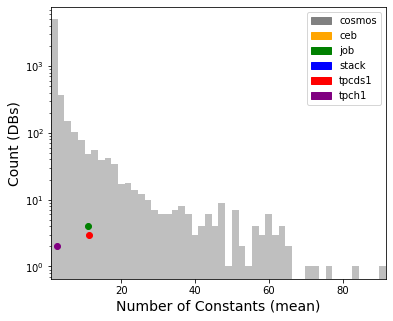

In [233]:
plot_distribution(pconsts, "mean", "Number of Constants ({})".format("mean"), xlim=(0,100), 
                  prefix="IncludesSubqueries")

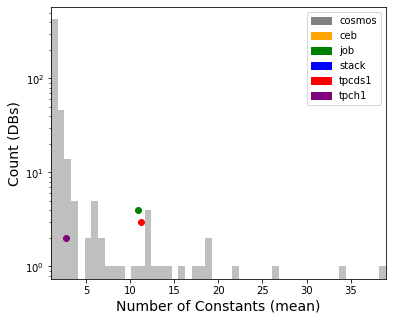

In [234]:
plot_distribution(pconsts1, "mean", "Number of Constants ({})".format("mean"), "")

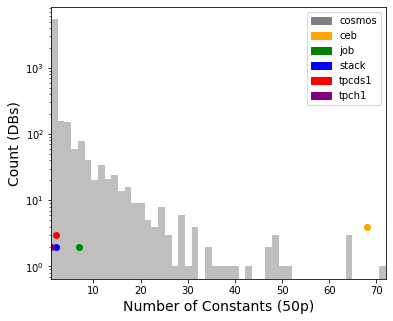

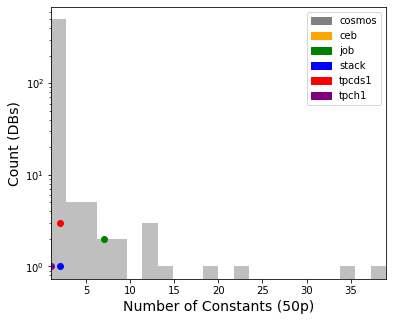

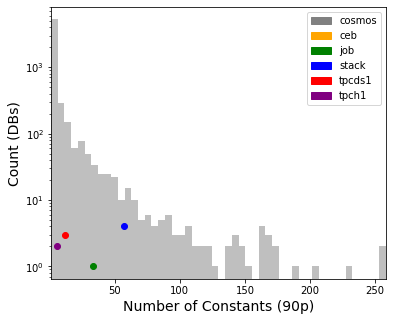

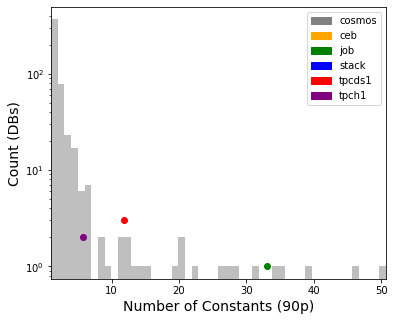

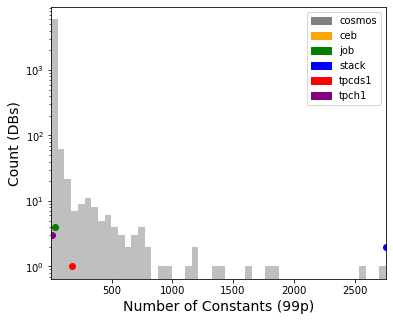

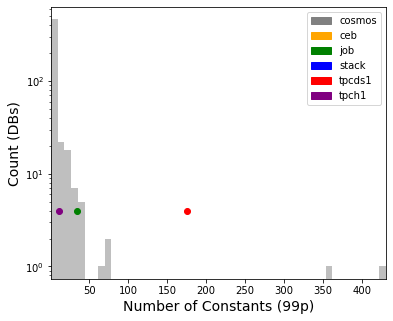

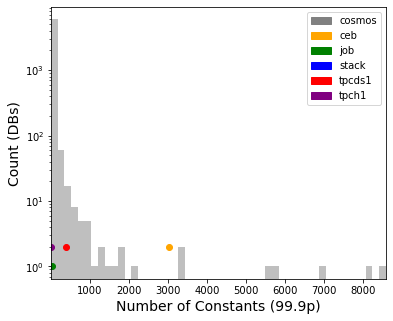

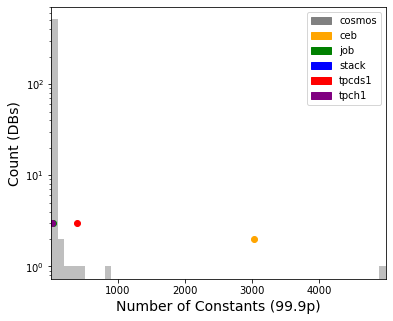

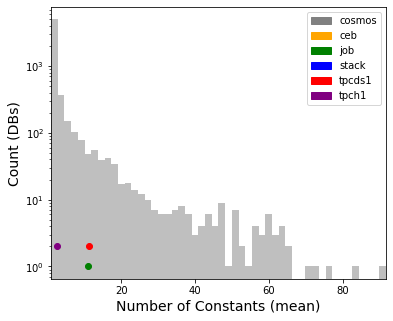

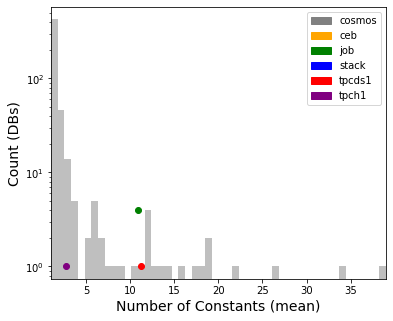

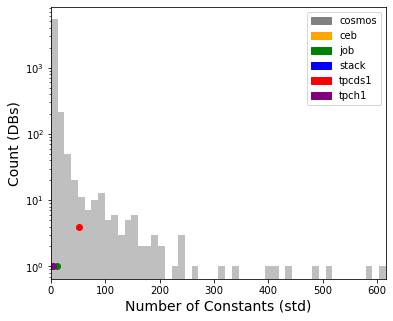

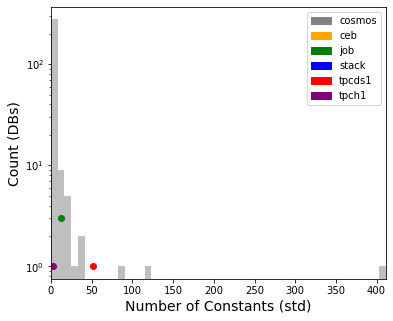

In [235]:
for p in PERCENTILES:
    plot_distribution(pconsts, p, "Number of Constants ({})".format(p), prefix="IncludesSubqueries")
    plot_distribution(pconsts1, p, "Number of Constants ({})".format(p), prefix="")

# Discrete Predicates on ID columns

In [236]:
def check_id(row):
    col = row["column"].lower()
    if "id" in col and is_int(row["constant"]):
        return True
    else:
        return False

In [62]:
#discdf["is_id"] = discdf.apply(lambda x: check_id(x) ,axis=1)

In [63]:
# iddf = discdf[discdf.is_id == True]
# set(iddf["column"])

# Number of unique LIKE constants (and showing how common they are across multiple inputs etc.)

In [64]:
likedf = opdf[opdf.op.isin(["LIKE"])]
print(len(likedf))
#likedf = likedf.drop_duplicates(["constant", "input", "column", "db"])
#print(len(likedf))
likedf = likedf[likedf.workload == "cosmos"]

521273


In [65]:
# tmp = likedf[likedf.constant == "ndrcode"]
# tmp

In [66]:
print(len(likedf))
print(len(set(likedf["constant"])))

513232
6117


In [67]:
pd.options.display.max_colwidth = 1000
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

In [68]:
HTML(likedf.groupby(["constant"])["op"].count().reset_index().sort_values(by="op", ascending=False).head(100).to_html())

,constant,op
4070,ndrcode,55599
1343,actorids,40830
4128,no_dump,39308
1671,bad_dump,39308
3880,missing_dump,39308
5243,tags,22599
5163,states,22597
5301,te.processhost.exe,20905
3746,measures,18233
5376,timesinms,18233


In [69]:
likedf = opdf[opdf.op.isin(["LIKE"])]
print(len(likedf))
#likedf = likedf.drop_duplicates(["constant", "input", "column", "db"])
#print(len(likedf))
likedf = likedf[likedf.workload == "job"]

521273


In [70]:
print(len(likedf))
print(len(set(likedf["constant"])))

194
75


In [71]:
HTML(likedf.groupby(["constant"])["op"].count().reset_index().sort_values(by="op", ascending=False).head(100).to_html())

,constant,op
8,'%(USA)%',14
1,'%(200%)%',10
25,'%Film%',8
44,'%follow%',8
39,'%Warner%',8
46,'%internet%',7
18,'%An%',7
24,'%Downey%Robert%',6
49,'%sequel%',6
43,'%complete%',6


In [72]:
likedf = opdf[opdf.op.isin(["LIKE"])]
tmp = likedf.groupby(["workload", "constant"])["op"].count().reset_index()

In [73]:
tmp.groupby(["workload"])["op"].describe(percentiles=[0.9, 0.99])

,count,mean,std,min,50%,90%,99%,max
workload,,,,,,,,
ceb,634.0,2.805994,6.476246,1.0,1.0,5.0,20.67,103.0
cosmos,6117.0,83.902567,1402.113586,1.0,2.0,16.0,1226.00,55599.0
job,75.0,2.586667,2.563219,1.0,1.0,6.0,11.04,14.0
stack,1300.0,4.664615,8.420336,1.0,2.0,10.0,38.03,122.0
tpcds1,1.0,1.000000,NaN,1.0,1.0,1.0,1.00,1.0
tpch1,3.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0


# Selectivity Patterns

### Multidimensional filters ---> dramatically less selectivity (is this matched in multidimensional filters on other dbs?)

### LIKE filters ---> a lot less selectivity; seems unlikely to match in JOB and CEB and others

In [74]:
#set(exprdf["StageName"])

In [75]:

#seldf.groupby(["cluster"])["Selectivity"].describe(percentiles=[0.25,0.75, 0.90, 0.95, 0.99])

In [76]:
#seldf1.groupby(["cluster"])["Selectivity"].describe(percentiles=[0.25,0.75, 0.90, 0.95, 0.99])

In [77]:
# print(len(seldf), len(set(seldf["db"])))
# print(len(seldf1), len(set(seldf1["db"])))

In [78]:
#seldbs = dbcounts[dbcounts["jobid"] >= 10]["db"].values
#seldbs = list(seldbs) + WKS
#selmeans = seldf.groupby(["db", "cluster", "workload"])[["Selectivity", "cont_ops", "discrete_ops"]].mean().reset_index()

In [237]:
psels = {}
PERCENTILES = ["50%", "90%", "99%", "99.9%", "mean", "std"]

In [238]:
seldf = exprdf[exprdf["RowCount"] != -1]
seldf1 = exprdf1[exprdf1["RowCount"] != -1]

selps = seldf.groupby(["db"])["Selectivity"].describe(percentiles=[0.5, 0.75, 0.9, 0.99, 0.999]).reset_index()
selps1 = seldf1.groupby(["db"])["Selectivity"].describe(percentiles=[0.5, 0.75, 0.9, 0.99, 0.999]).reset_index()
selps = selps[selps.db.isin(seldbs)]

selps1 = selps1[selps1.db.isin(seldbs1)]
print(len(selps))
print(len(selps1))

6302
1008


In [239]:
print(len(seldbs))
print(len(seldbs1))

6308
1014


In [240]:
selps = selps.merge(dbmeans, on="db", how="inner")
selps1 = selps1.merge(dbmeans1, on="db", how="inner")
print(len(selps))
print(len(selps1))
selps1.head(5)

6302
1008


,db,count,mean,std,min,50%,75%,90%,99%,99.9%,max,cluster,workload,cont_ops,discrete_ops,like_ops
0,ceb,21045.0,0.304178,0.349906,4.118765e-07,0.151789,0.428652,1.000000,1.000000,1.000000,1.000000,ceb,ceb,0.145946,0.786426,0.072302
1,cosmos08-0310139,13.0,0.166079,0.143140,1.635485e-03,0.090453,0.298434,0.308346,0.360069,0.366354,0.367052,cosmos08,cosmos,0.000000,0.461538,0.538462
2,cosmos08-10168173,30.0,1.000000,0.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,cosmos08,cosmos,0.944785,0.079755,0.000000
3,cosmos08-10168411,18.0,0.014661,0.001832,1.202551e-02,0.014275,0.016135,0.017100,0.017916,0.017977,0.017983,cosmos08,cosmos,0.000000,1.000000,1.000000
4,cosmos08-1016875,12.0,0.006501,0.008996,0.000000e+00,0.001941,0.008229,0.021687,0.024237,0.024444,0.024467,cosmos08,cosmos,0.000000,1.000000,0.000000


/home/pari/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


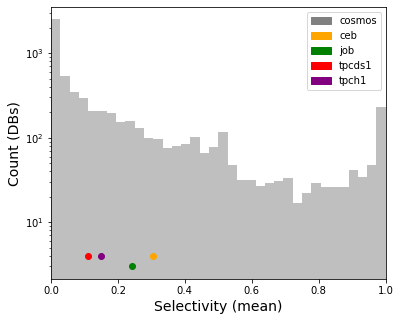

In [241]:
plot_distribution(selps, "mean", "Selectivity ({})".format("mean"), xlim=(0,100), 
                  prefix="IncludesSubqueries")

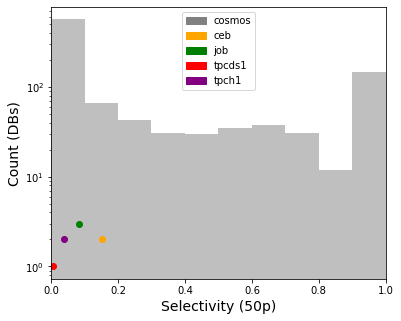

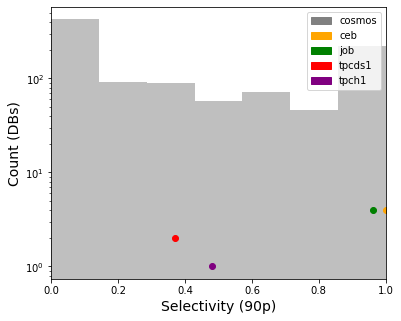

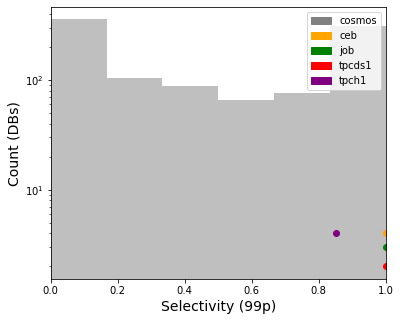

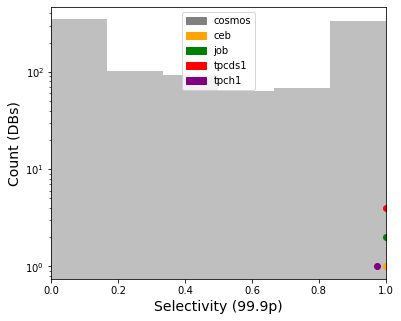

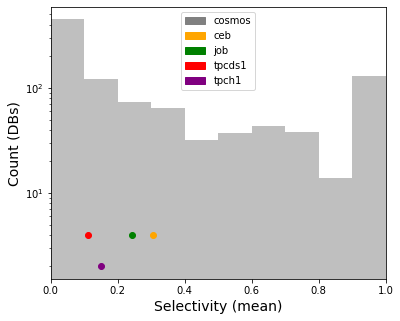

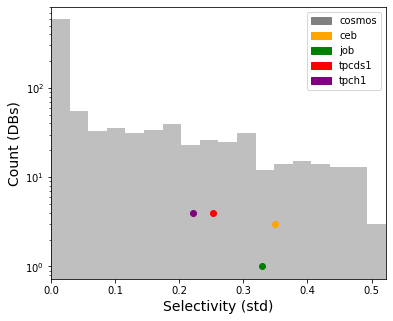

In [186]:
for p in PERCENTILES:
#     plot_distribution(selps, p, "Selectivity ({})".format(p), xlim=None, 
#                   prefix="IncludesSubqueries")
    plot_distribution(selps1, p, "Selectivity ({})".format(p), xlim=None, 
              prefix="")
    
#     print(p)
#     sns.distplot(selps[p], kde=False)
#     #plt.yscale("log")
#     plt.show()
#     sns.distplot(selps1[p], kde=False)
#     plt.yscale("log")
#     plt.show()

In [242]:
# def plot_sel_fig(df, p):
#     means1 = df[df.workload == "cosmos"]
#     means2 = df[df.workload != "cosmos"]
#     fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(8,5))
    
#     sns.scatterplot(data=means1, x="cont_ops", y=p, alpha=0.3, hue="workload", palette=["grey"])
#     sns.scatterplot(data=means2, x="cont_ops", y=p, alpha=1.0, hue="workload", s=100, palette=DSCOLORS)

# #     ax.legend(title="Workload", bbox_to_anchor=(0.1, 1.00), ncol=5,
# #          frameon = True, fontsize=10)
    
#     ax.legend(title="Workload", bbox_to_anchor=(0.1, 1.00), ncol=5,
#              frameon = True, fontsize=10)
#     ax.set_ylabel("Selectivity", fontsize=14)
#     ax.set_xlabel("Continuous Filters (Fraction)", fontsize=14)

#     #plt.savefig("Discrete-Continuous.png", dpi=200)
#     plt.show()

FN_TMP = "./dataset_comparison/{prefix}{xlabel}-{ylabel}.png"

def plot_sel_fig(df, x, y, xlabel, ylabel, prefix=""):
    means1 = df[df.workload == "cosmos"]
    means2 = df[df.workload != "cosmos"]
    fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(8,6))
    xlabel = xlabel.replace("%", "p")
    ylabel = ylabel.replace("%", "p")
    
    sns.scatterplot(data=means1, x=x, y=y, alpha=0.3, hue="workload", palette=["grey"])
    sns.scatterplot(data=means2, x=x, y=y, alpha=1.0, hue="workload", s=100, palette=DSCOLORS)
    
    ax.legend(title="Workload",
              #bbox_to_anchor=(, 1.10), 
              loc="upper center",
              ncol=3,
             frameon = True, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    
    if len(prefix) != 0:
        prefix += "-"
    
    fn = FN_TMP.format(prefix=prefix,
                       xlabel=xlabel, 
                       ylabel=ylabel)
    
    fn = fn.replace(" ", "_")
    
    plt.savefig(fn, dpi=200, facecolor='w')
    plt.show()
    plt.close()

50%


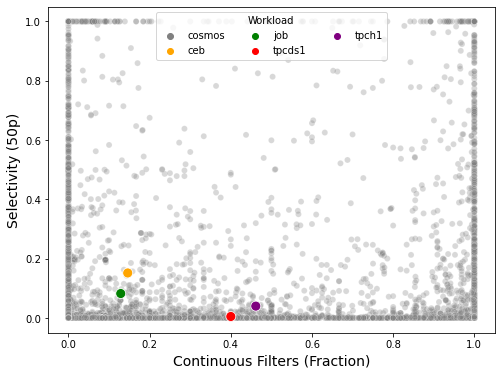

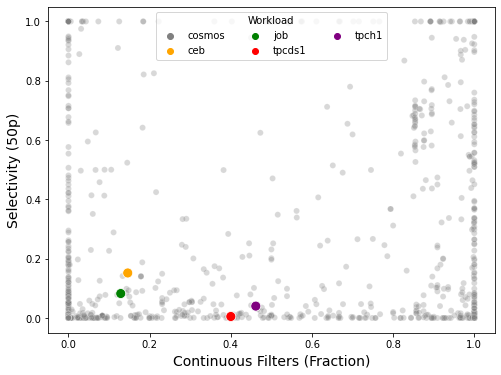

90%


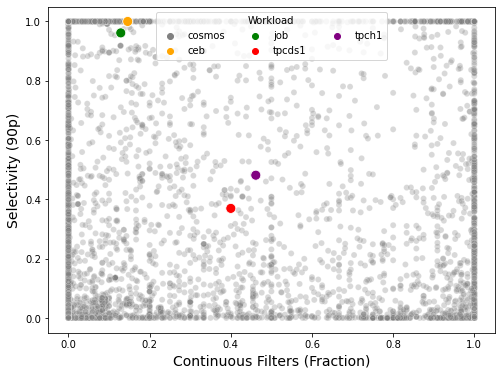

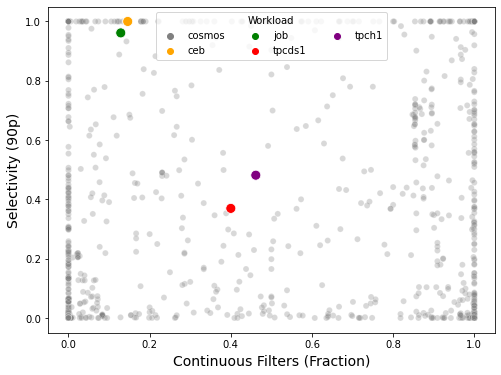

99%


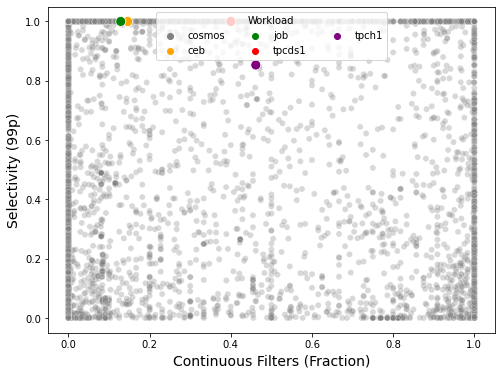

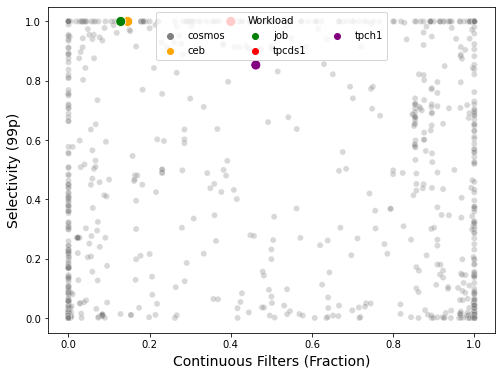

99.9%


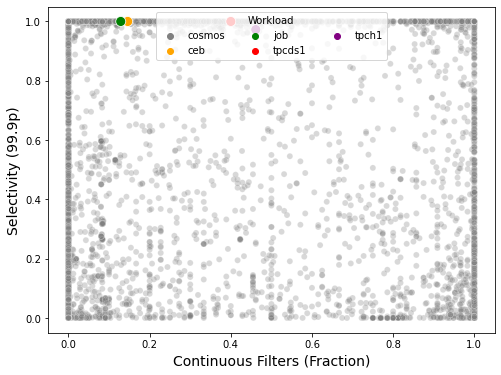

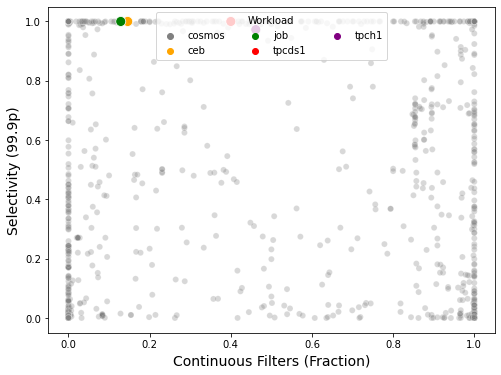

mean


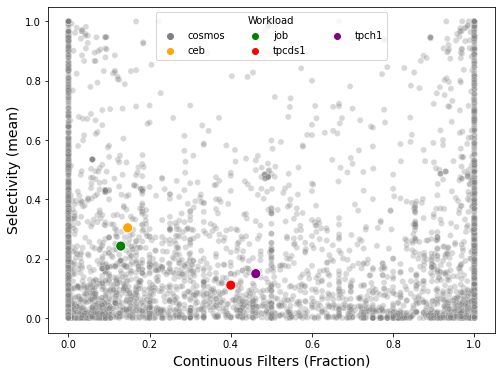

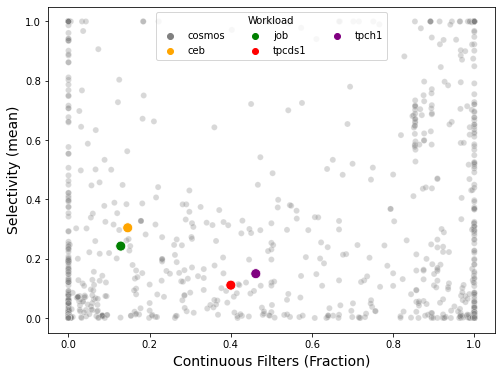

std


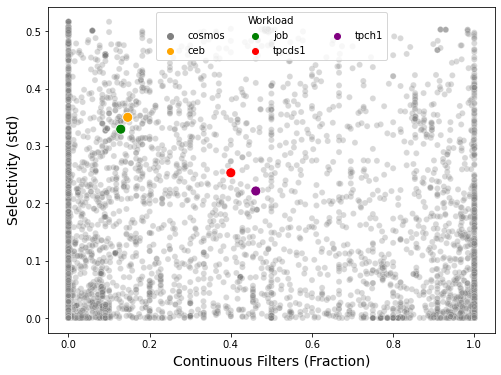

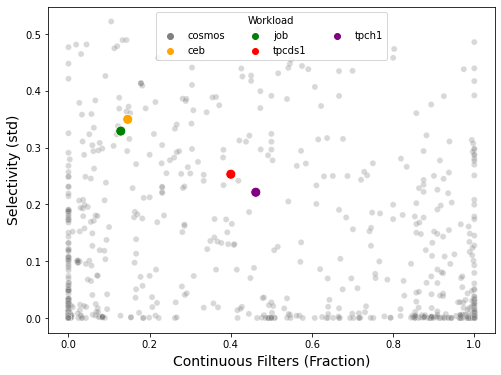

In [243]:
for p in PERCENTILES:
    print(p)
    plot_sel_fig(selps, "cont_ops", p, "Continuous Filters (Fraction)", "Selectivity ({})".format(p), 
                prefix="IncludesSubqueries")
    plot_sel_fig(selps1, "cont_ops", p, "Continuous Filters (Fraction)", "Selectivity ({})".format(p), 
            prefix="")
    plt.show()

In [159]:
# for p in PERCENTILES:
#     print(p)
#     plot_sel_fig(selps1, "cont_ops", p, "Continuous Filters (Fraction)", "Selectivity ({})".format(p),
#                 prefix="")
#     plt.show()

In [160]:
selmeans = selmeans[selmeans.db.isin(seldbs)]
selmeans["Selectivity"].describe()

NameError: name 'selmeans' is not defined

In [161]:
tmp2 = selmeans[selmeans["Selectivity"] == 0]
print(len(tmp2))

NameError: name 'selmeans' is not defined

In [90]:
sns.distplot(selmeans["Selectivity"], kde=False)
#sns.distplot(dbmeans["discrete_ops"], kde=False)
#sns.distplot(dbmeans["like_ops"], kde=False)
plt.yscale("log")

NameError: name 'selmeans' is not defined

In [91]:
# means1 = selmeans[selmeans.workload == "cosmos"]
# #means2 = dbmeans[dbmeans.workload != "cosmos"]
# fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(8,5))

# sns.scatterplot(data=means1, x="cont_ops", y="Selectivity", alpha=0.3, hue="workload", palette=["grey"])
# #sns.scatterplot(data=means2, x="cont_ops", y="discrete_ops", alpha=1.0, hue="workload", s=100, palette=DSCOLORS)

# ax.legend(title="Workload", bbox_to_anchor=(0.1, 1.00), ncol=5,
#          frameon = True, fontsize=10)

# ax.set_ylabel("Selectivity", fontsize=14)
# ax.set_xlabel("Continuous Filters (Fraction)", fontsize=14)

# #plt.savefig("Discrete-Continuous.png", dpi=200)
# plt.show()

# Number of unique filter columns per job

In [92]:
exprdf.keys()

Index(['jobid', 'input', 'unique_filter_cols', 'discrete_ops', 'cont_ops',
       'like_ops', 'num_unique_ops', 'num_ops', 'num_discrete_consts',
       'num_likes', 'like_lens', 'workload', 'db', 'cluster', 'StageName',
       'InputCardinality', 'RowCount', 'Selectivity', 'Stage1'],
      dtype='object')

In [93]:
exprdf = exprdf[~exprdf.input.isin(["X", "function"])]

In [94]:
exprdf.groupby("workload")["unique_filter_cols"].describe(percentiles=[0.75, 0.9, 0.99, 0.999])

,count,mean,std,min,50%,75%,90%,99%,99.9%,max
workload,,,,,,,,,,
ceb,24605.0,1.028409,0.166141,1.0,1.0,1.0,1.0,2.00,2.000,2.0
cosmos,7752993.0,1.369419,0.880474,1.0,1.0,1.0,2.0,5.00,8.000,38.0
job,598.0,1.065217,0.247116,1.0,1.0,1.0,1.0,2.00,2.000,2.0
stack,33035.0,1.168155,0.527987,1.0,1.0,1.0,2.0,4.00,5.000,6.0
tpcds1,267.0,1.483146,0.684617,1.0,1.0,2.0,2.0,3.34,4.734,5.0
tpch1,36.0,1.250000,0.603561,1.0,1.0,1.0,2.0,3.00,3.000,3.0


In [95]:
seldbs = dbcounts[dbcounts["jobid"] >= 10]["db"].values
#seldbs = list(seldbs) + WKS

In [96]:
print(len(seldbs))

6303


In [97]:
dbfiltercols = exprdf.groupby("input")["unique_filter_cols"].max().reset_index()
#dbfiltercols = dbfiltercols[dbfiltercols.db.isin(seldbs)]

/home/pari/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


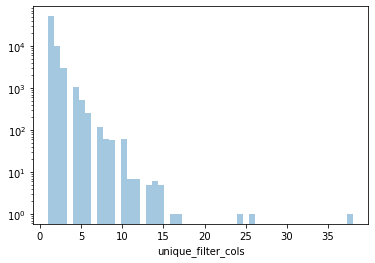

In [98]:
sns.distplot(dbfiltercols["unique_filter_cols"], kde=False)
plt.yscale("log")
#plt.xscale("log")

In [99]:
exprdf.groupby(["input", "workload"])["unique_filter_cols"].max().reset_index()

,input,workload,unique_filter_cols
0,-2147391892,cosmos,1
1,-2147344906,cosmos,1
2,-2147276645,cosmos,1
3,-2147221786,cosmos,1
4,-2147202637,cosmos,1
...,...,...,...
66596,web_sales,tpcds1,3
66597,web_site,tpcds1,1
66598,whitelist,stack,1
66599,wiki,stack,2


In [100]:
dbfiltercols = exprdf.groupby("input")["unique_filter_cols"].mean().reset_index()
#dbfiltercols = dbfiltercols[dbfiltercols.db.isin(seldbs)]

/home/pari/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


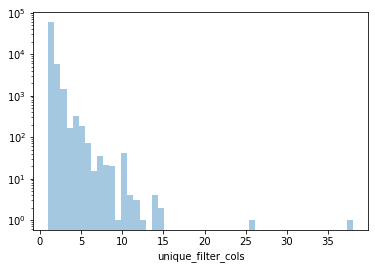

In [101]:
sns.distplot(dbfiltercols["unique_filter_cols"], kde=False)
plt.yscale("log")
#plt.xscale("log")

In [102]:
def pretty_print(df):
    return display( HTML( df.to_html(index=False).replace("\\n","<br>") ) )

In [103]:
# #STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount", "exploratory_job", "templated_job"]
# STATSTODROP = ["std", "min", "max"]
# STATCOLS = ["Selectivity", "InputCardinality"]
# curdrops = []
# for si, stc in enumerate(STATCOLS):
#     for sdrop in STATSTODROP:
#         curdrops.append(tuple([stc, sdrop]))
#     if si != 0:
#         curdrops.append(tuple([stc,"count"]))

# #curdrops.append(tuple(["QError","mean"]))
# #curdrops.append(tuple(["VertexCount","mean"]))
# #print(curdrops)
# pretty_print(cdf.groupby(["unique_filter_cols"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
#      reset_index().\
#      #.sort_values(by=("Selectivity","count"), ascending=False).\
#      rename(columns={"cont_ops":"> or <", "discrete_ops":"=,!=", "like_ops":"LIKE"}).\
#      drop(columns=curdrops).round(2))

# Multi-Dimensional Filter Kinds

In [104]:
multidf = exprdf[exprdf.unique_filter_cols == 2]

In [105]:
def kind_multi_dim_index(row):
    kinds = []
    if row["discrete_ops"] == 1:
        kinds.append("discrete")
        
    if row["cont_ops"] == 1:
        kinds.append("cont")
        
    if row["like_ops"] == 1:
        kinds.append("like")
    
    kinds.sort()
    return ",".join(kinds)

In [106]:
multidf["multikind"] = multidf.apply(lambda x: kind_multi_dim_index(x) , axis=1)

/tmp/ipykernel_3449667/319002343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multidf["multikind"] = multidf.apply(lambda x: kind_multi_dim_index(x) , axis=1)


In [107]:
multidf.groupby("multikind")["jobid"].describe()

,count,unique,top,freq
multikind,,,,
cont,54559,13324,84beead7-4626-4aec-9081-736a97feb48e,1655
"cont,discrete",437574,50303,ad49cde6-c115-44e3-99f2-e7239dc14f77,1620
"cont,discrete,like",1049,647,045c4c37-e337-4a5e-8eed-9c637c48adbd,2
"cont,like",67788,2597,5e9d137d-291c-4e09-aaf5-439170b2b68a,848
discrete,340187,37501,558784e6-15eb-4414-883e-63fdc393e94d,2177
"discrete,like",95789,5771,20fe1d3d-2a75-45bf-9dd5-0114c62547ce,7473
like,1239,1106,ebb7b2c2-b3ef-4606-95f0-9dd1df03cb5a,42


In [108]:
multidf.groupby(["workload", "multikind"])["jobid"].describe()

count unique  \
workload multikind                           
ceb      cont,discrete          115    114   
         discrete               584    528   
cosmos   cont                 54084  12856   
         cont,discrete       436416  49192   
         cont,discrete,like    1045    643   
         cont,like            67501   2311   
         discrete            339035  36468   
         discrete,like        95410   5398   
         like                  1127    995   
job      cont,like                6      6   
         discrete                 2      2   
         discrete,like           25     24   
         like                     6      6   
stack    cont                   469    464   
         cont,discrete         1022    984   
         cont,discrete,like       4      4   
         cont,like              281    280   
         discrete               506    493   
         discrete,like          353    348   
         like                   106    105   
tpcds1   cont                     6      4   
         cont,discrete           20     16   
         discrete                59     38   
tpch1    cont,discrete            1      1   
         discrete                 1      1   
         discrete,like            1      1   

                                                              top  freq  
workload multikind                                                       
ceb      cont,discrete                                        150     2  
         discrete                                             528     3  
cosmos   cont                84beead7-4626-4aec-9081-736a97feb48e  1655  
         cont,discrete       ad49cde6-c115-44e3-99f2-e7239dc14f77  1620  
         cont,discrete,like  323821e3-e4c2-4bad-abb5-b7153f687fd3     2  
         cont,like           2ef91502-8b50-4ef8-96cd-b3be36ff3974   848  
         discrete            558784e6-15eb-4414-883e-63fdc393e94d  2177  
         discrete,like       20fe1d3d-2a75-45bf-9dd5-0114c62547ce  7473  
         like                ebb7b2c2-b3ef-4606-95f0-9dd1df03cb5a    42  
job      cont,like                                              4     1  
         discrete                                               0     1  
         discrete,like                                        100     2  
         like                                                   0     1  
stack    cont                                               56050     2  
         cont,discrete                                      58926     3  
         cont,discrete,like                                 11540     1  
         cont,like                                           8160     2  
         discrete                                            8250     2  
         discrete,like                                      69495     2  
         like                                               32585     2  
tpcds1   cont                                                  25     3  
         cont,discrete                                         30     2  
         discrete                                              56     6  
tpch1    cont,discrete                                         11     1  
         discrete                                              22     1  
         discrete,like                                         10     1

# Number of filter columns per input

In [109]:
fcols = opdf.groupby(["input", "workload", "cluster"])["column"].nunique().reset_index()\
    .rename(columns={"column":"AllFilterColumns"})
fcols = fcols[~fcols.input.isin(["X", "function"])]

In [110]:
fcols.groupby(["workload"])["AllFilterColumns"].describe(percentiles=[0.9, 0.99, 0.999])

,count,mean,std,min,50%,90%,99%,99.9%,max
workload,,,,,,,,,
ceb,12.0,1.500000,1.167748,1.0,1.0,2.0,4.67,4.967,5.0
cosmos,62626.0,2.070051,2.886360,1.0,1.0,4.0,13.00,28.000,280.0
job,17.0,1.352941,0.701888,1.0,1.0,2.4,3.00,3.000,3.0
stack,361.0,2.116343,3.864767,1.0,1.0,3.0,18.60,37.640,38.0
tpcds1,35.0,3.314286,2.867377,1.0,2.0,8.6,10.32,10.932,11.0
tpch1,7.0,3.000000,2.236068,1.0,2.0,5.8,6.88,6.988,7.0


In [111]:
tmp = fcols[fcols["AllFilterColumns"] == 38]
tmp

,input,workload,cluster,AllFilterColumns
38203,480834419,cosmos,cosmos14,38
57313,1782524463,cosmos,cosmos15,38
62437,2134481566,cosmos,cosmos15,38
62952,posts,stack,stack,38


In [112]:
ccols = fcols[fcols.workload == "cosmos"]
dballcols = ccols.groupby("input")["AllFilterColumns"].max().reset_index()
#dballcols = dballcols[dballcols.db.isin(seldbs)]

/home/pari/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


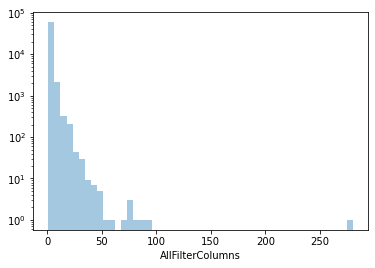

In [113]:
sns.distplot(dballcols["AllFilterColumns"], kde=False)
plt.yscale("log")

# Combine input allcols and uniquefiltercols

In [114]:
#exprdf = exprdf[exprdf.input.isin()]

In [115]:
#GROUP_FIELD = "input"

In [116]:
#udf = exprdf.groupby([GROUP_FIELD, "workload"])["unique_filter_cols"].max().reset_index()
#udf = exprdf.groupby(["db", "workload"])["unique_filter_cols"].mean().reset_index()
#udf = udf[udf.db.isin(seldbs)]

In [117]:
udf = opdf.groupby(["db", "exprhash", "workload"])["column"].nunique().reset_index()
udf = udf.groupby(["db", "workload"])["column"].mean().reset_index().rename(columns={"column":"UniqueFilterCols"})

In [118]:
#fcols = fcols[~fcols.input.isin(["X", "function"])]
#fcols = fcols[fcols.db.isin(seldbs)]
fcols = opdf.groupby(["db", "input", "workload", "cluster"])["column"].nunique().reset_index()

In [119]:
fcols = fcols.groupby(["db", "workload"])["column"].mean().reset_index().rename(columns={"column":"AllFilterColumns"})
#fcols

In [120]:
#print(len(set(fcols["input"])), len(set(udf["input"])))
#print(len(set(fcols[GROUP_FIELD])), len(set(udf[GROUP_FIELD])))

In [121]:
fcols = fcols[fcols["db"].isin(udf["db"].values)]

In [122]:
cmb = udf.merge(fcols, on=["db", "workload"])
#cmb.head(50)

<AxesSubplot:xlabel='UniqueFilterCols', ylabel='AllFilterColumns'>

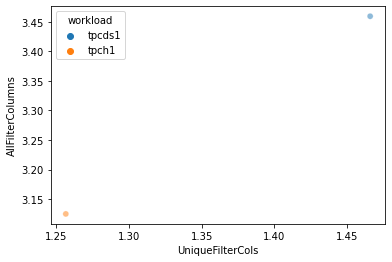

In [123]:
cmbtpc = cmb[cmb.workload.str.contains("tpc")]
sns.scatterplot(data=cmbtpc, x="UniqueFilterCols", y="AllFilterColumns", hue="workload", alpha=0.5)

<AxesSubplot:xlabel='UniqueFilterCols', ylabel='AllFilterColumns'>

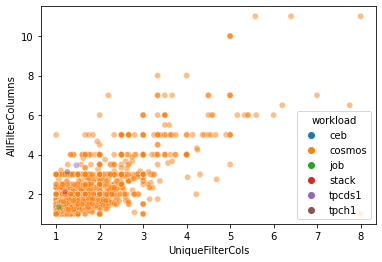

In [124]:
sns.scatterplot(data=cmb, x="UniqueFilterCols", y="AllFilterColumns", hue="workload", alpha=0.5)

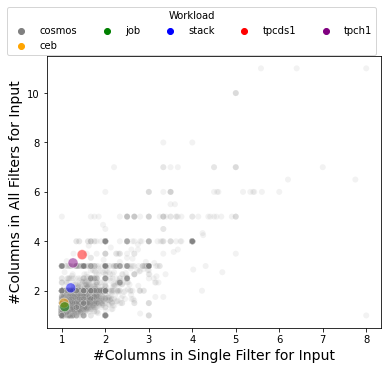

In [125]:
means1 = cmb[cmb.workload == "cosmos"]
means2 = cmb[cmb.workload != "cosmos"]
fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(6,5))

sns.scatterplot(data=means1, x="UniqueFilterCols", y="AllFilterColumns", alpha=0.1, hue="workload", palette=["grey"])
sns.scatterplot(data=means2, x="UniqueFilterCols", y="AllFilterColumns", alpha=0.5, hue="workload", 
                s=100, palette=DSCOLORS)

# ax.legend(title="Workload", bbox_to_anchor=(0.20, 1.00), ncol=2,
#          frameon = False, fontsize=14)
ax.legend(title="Workload", bbox_to_anchor=(1, 1.20), ncol=5,
         frameon = True, fontsize=10)
#ax.set_yscale("log")
#ax.set_xlim([0,15])

ax.set_ylabel("#Columns in All Filters for Input", fontsize=14)
ax.set_xlabel("#Columns in Single Filter for Input", fontsize=14)

plt.savefig("AllColumns-vs-FilterColumn.png", dpi=200)
plt.show()

# Continuous vs #Columns

In [126]:
# def plot_sel_fig(df, x, y, xlabel, ylabel):
#     means1 = df[df.workload == "cosmos"]
#     means2 = df[df.workload != "cosmos"]
#     fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(8,6))
    
#     sns.scatterplot(data=means1, x=x, y=y, alpha=0.3, hue="workload", palette=["grey"])
#     sns.scatterplot(data=means2, x=x, y=y, alpha=1.0, hue="workload", s=100, palette=DSCOLORS)
    
#     ax.legend(title="Workload",
#               #bbox_to_anchor=(, 1.10), 
#               ncol=3,
#              frameon = True, fontsize=10)
#     ax.set_ylabel(ylabel, fontsize=14)
#     ax.set_xlabel(xlabel, fontsize=14)

#     #plt.savefig("Discrete-Continuous.png", dpi=200)
#     plt.show()
#     plt.close()

In [244]:
udf = opdf.groupby(["db", "exprhash", "workload"])["column"].nunique().reset_index()
udf = udf.groupby(["db", "workload"])["column"].describe(percentiles=[0.5, 0.75, 0.9, 0.99, 0.999]).reset_index()
udf = udf[udf.db.isin(seldbs)]
udf = udf.merge(dbmeans, on=["db", "workload"], how="inner")
udf

,db,workload,count,mean,std,min,50%,75%,90%,99%,99.9%,max,cluster,cont_ops,discrete_ops,like_ops
0,ceb,ceb,17796.0,1.047426,0.226382,1.0,1.0,1.0,1.0,2.00,3.000,3.0,ceb,0.145946,0.786426,0.072302
1,cosmos08-0310105,cosmos,74.0,1.797297,1.292547,1.0,1.0,2.0,4.0,5.00,5.000,5.0,cosmos08,0.220779,0.915584,0.000000
2,cosmos08-0310137,cosmos,30.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.00,1.000,1.0,cosmos08,0.000000,1.000000,0.000000
3,cosmos08-0310139,cosmos,13.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.00,1.000,1.0,cosmos08,0.000000,0.461538,0.538462
4,cosmos08-0310156,cosmos,50.0,1.020000,0.141421,1.0,1.0,1.0,1.0,1.51,1.951,2.0,cosmos08,0.150000,0.900000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6295,cosmos15-9911838,cosmos,26.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.00,1.000,1.0,cosmos15,1.000000,0.000000,0.000000
6296,job,job,598.0,1.065217,0.247116,1.0,1.0,1.0,1.0,2.00,2.000,2.0,job,0.128763,0.722408,0.204013
6297,stack,stack,31145.0,1.203789,0.581015,1.0,1.0,1.0,2.0,4.00,6.000,7.0,stack,0.371122,0.608536,0.105979
6298,tpcds1,tpcds1,281.0,1.466192,0.681199,1.0,1.0,2.0,2.0,3.20,4.720,5.0,tpcds1,0.400000,0.703571,0.003571


In [245]:
udf1 = opdf1.groupby(["db", "exprhash", "workload"])["column"].nunique().reset_index()
udf1 = udf1.groupby(["db", "workload"])["column"].describe(percentiles=[0.5, 0.75, 0.9, 0.99, 0.999]).reset_index()
udf1 = udf1[udf1.db.isin(seldbs1)]
udf1 = udf1.merge(dbmeans1, on=["db", "workload"], how="inner")
udf1

,db,workload,count,mean,std,min,50%,75%,90%,99%,99.9%,max,cluster,cont_ops,discrete_ops,like_ops
0,ceb,ceb,17796.0,1.047426,0.226382,1.0,1.0,1.00,1.0,2.00,3.000,3.0,ceb,1.459459e-01,0.786426,0.072302
1,cosmos08-10168173,cosmos,5.0,1.000000,0.000000,1.0,1.0,1.00,1.0,1.00,1.000,1.0,cosmos08,9.447853e-01,0.079755,0.000000
2,cosmos08-10168411,cosmos,3.0,1.000000,0.000000,1.0,1.0,1.00,1.0,1.00,1.000,1.0,cosmos08,0.000000e+00,1.000000,1.000000
3,cosmos08-1131782,cosmos,180.0,1.311111,0.726889,1.0,1.0,1.00,2.0,4.00,6.463,7.0,cosmos08,0.000000e+00,1.000000,0.000000
4,cosmos08-12327408,cosmos,2.0,1.000000,0.000000,1.0,1.0,1.00,1.0,1.00,1.000,1.0,cosmos08,5.000000e-01,0.388889,0.111111
5,cosmos08-13185199,cosmos,3.0,1.000000,0.000000,1.0,1.0,1.00,1.0,1.00,1.000,1.0,cosmos08,5.689655e-01,0.982759,0.017241
6,cosmos08-13185230,cosmos,1.0,1.000000,NaN,1.0,1.0,1.00,1.0,1.00,1.000,1.0,cosmos08,2.978723e-01,0.680851,0.021277
7,cosmos08-13185232,cosmos,2.0,1.000000,0.000000,1.0,1.0,1.00,1.0,1.00,1.000,1.0,cosmos08,7.692308e-02,0.871795,0.076923
8,cosmos08-1318591,cosmos,4.0,1.000000,0.000000,1.0,1.0,1.00,1.0,1.00,1.000,1.0,cosmos08,9.861111e-01,0.013889,0.000000
9,cosmos08-1403204,cosmos,1.0,1.000000,NaN,1.0,1.0,1.00,1.0,1.00,1.000,1.0,cosmos08,2.142857e-01,0.357143,0.500000


/home/pari/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


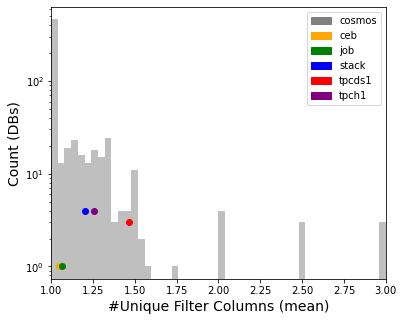

In [246]:
plot_distribution(udf1, "mean", "#Unique Filter Columns ({})".format("mean"), xlim=None, 
                  prefix="")

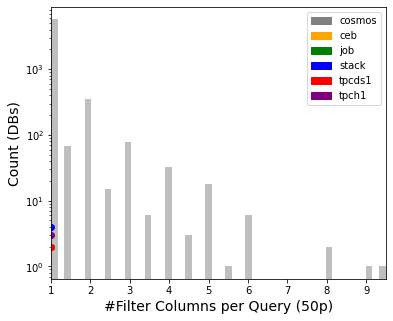

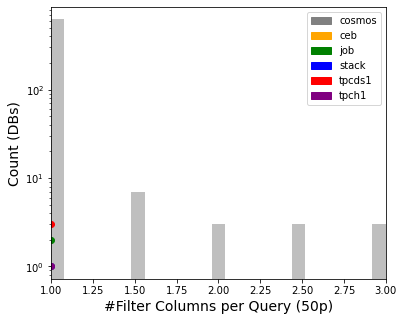

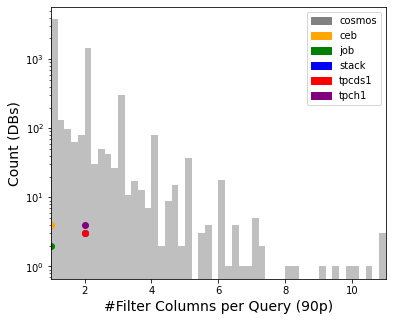

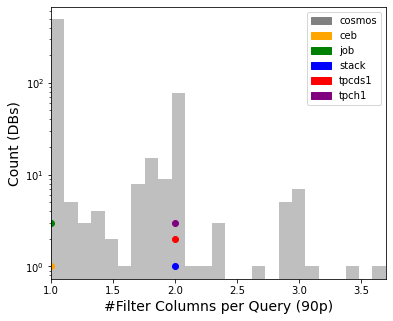

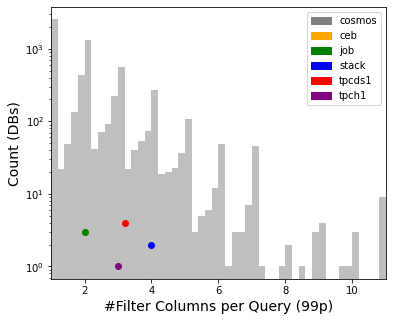

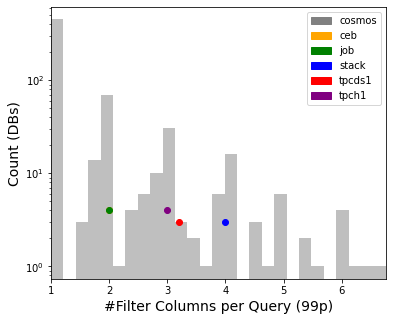

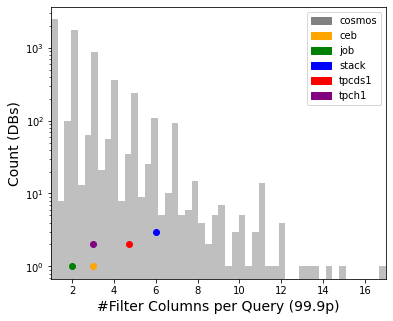

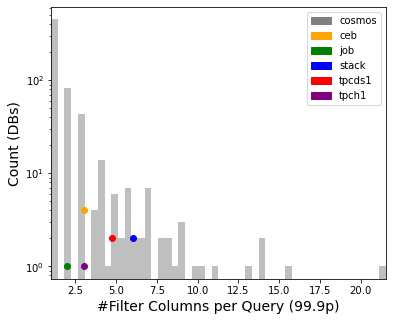

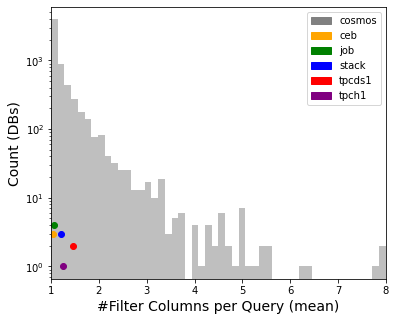

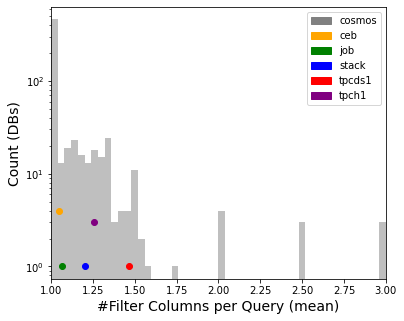

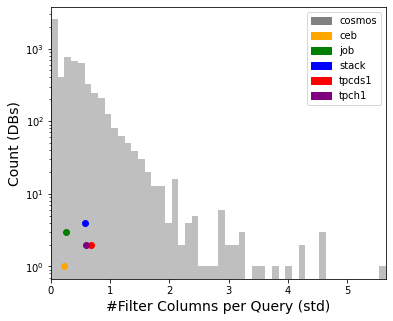

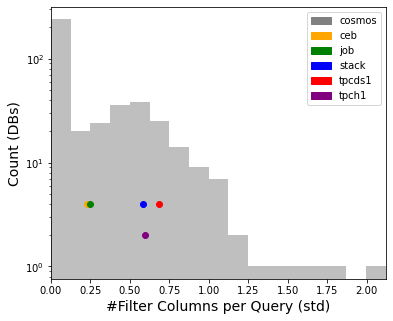

In [247]:
for p in PERCENTILES:
    plot_distribution(udf, p, "#Filter Columns per Query ({})".format(p), xlim=None, 
              prefix="IncludeSubqueries")
    plot_distribution(udf1, p, "#Filter Columns per Query ({})".format(p), xlim=None, 
          prefix="")

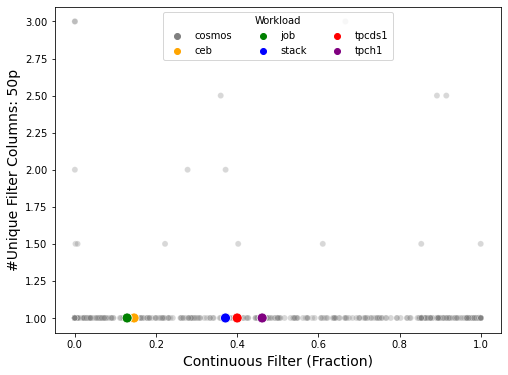

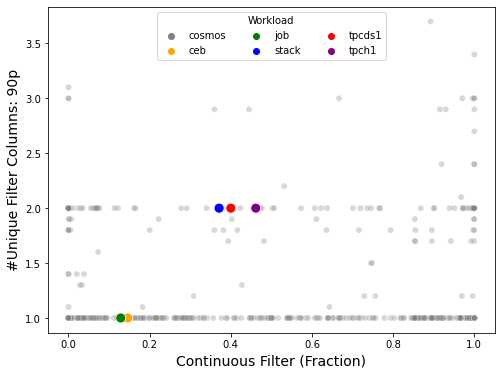

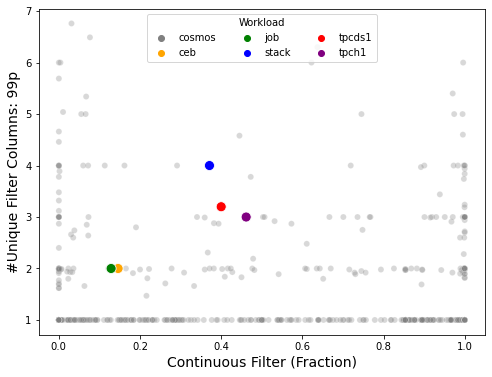

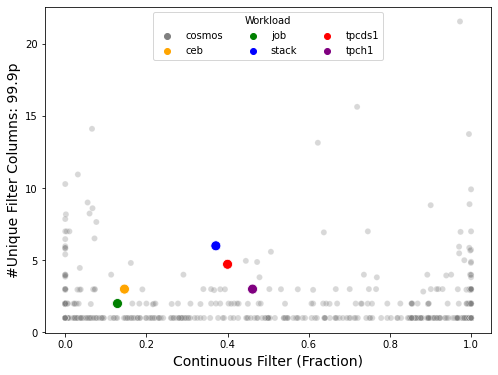

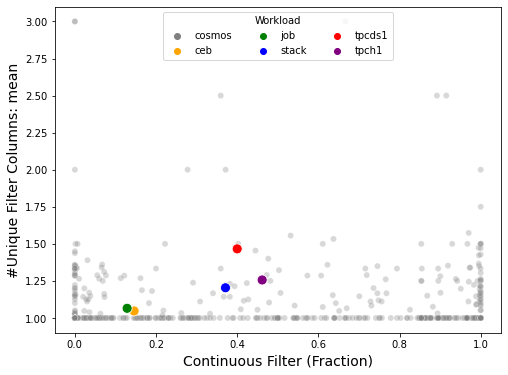

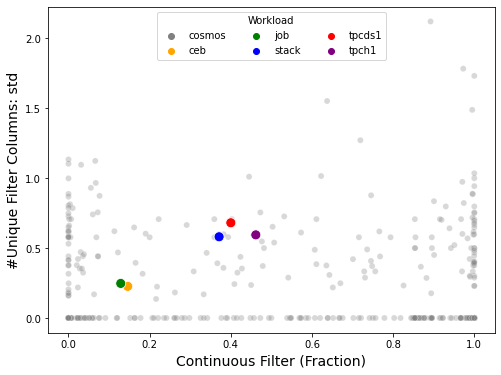

In [248]:
#def plot_sel_fig(df, x, y, xlabel, ylabel):

for p in PERCENTILES:
#     plot_sel_fig(udf, "cont_ops", p, "Continuous Filter (Fraction)", "#Unique Filter Columns: " + p,
#                 prefix="IncludesSubqueries")
    plot_sel_fig(udf1, "cont_ops", p, "Continuous Filter (Fraction)", "#Unique Filter Columns: " + p,
            prefix="")

In [249]:
fcols = opdf.groupby(["db", "input", "workload", "cluster"])["column"].nunique().reset_index()
fcols = fcols[fcols.db.isin(seldbs)]
fcols = fcols.groupby(["db", "workload"])["column"].describe(percentiles=[0.5,0.9,0.99, 0.999]).reset_index()
fcols = fcols.merge(dbmeans, on=["db", "workload"], how="inner")

In [250]:
fcols1 = opdf1.groupby(["db", "input", "workload", "cluster"])["column"].nunique().reset_index()
fcols1 = fcols1[fcols1.db.isin(seldbs1)]
fcols1 = fcols1.groupby(["db", "workload"])["column"].describe(percentiles=[0.5,0.9,0.99, 0.999]).reset_index()
fcols1 = fcols1.merge(dbmeans1, on=["db", "workload"], how="inner")

/home/pari/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


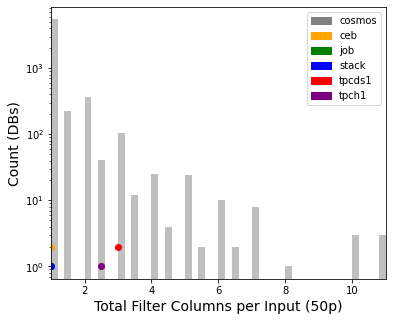

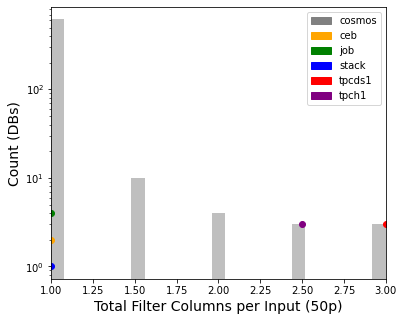

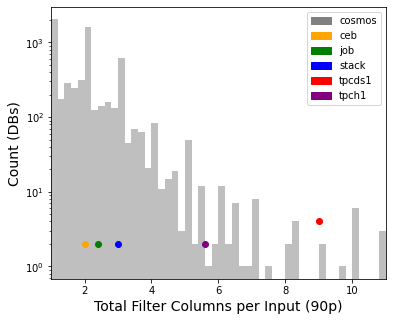

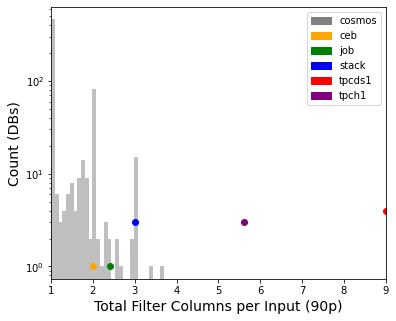

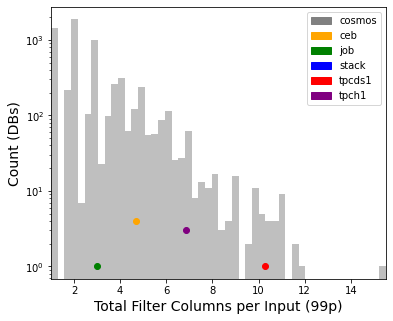

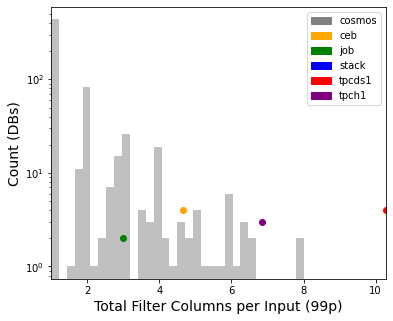

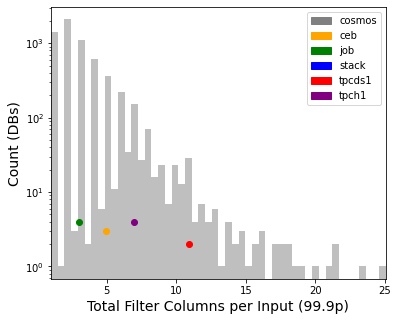

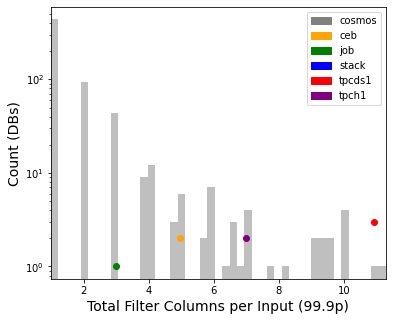

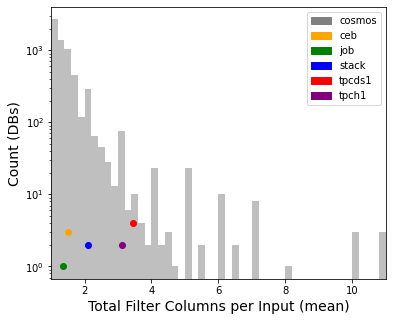

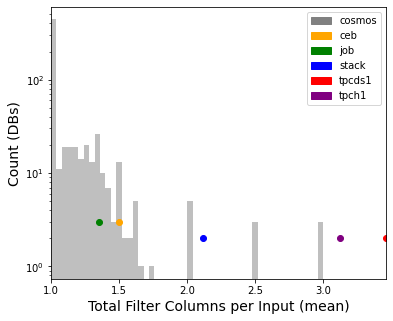

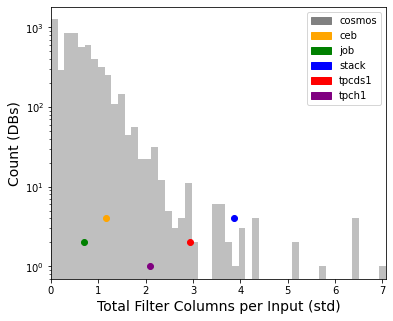

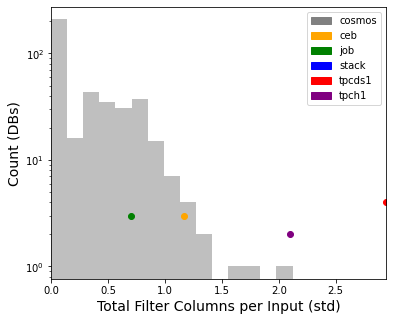

In [251]:
for p in PERCENTILES:
    plot_distribution(fcols, p, "Total Filter Columns per Input ({})".format(p), xlim=None, 
              prefix="IncludeSubqueries")
    plot_distribution(fcols1, p, "Total Filter Columns per Input ({})".format(p), xlim=None, 
          prefix="")

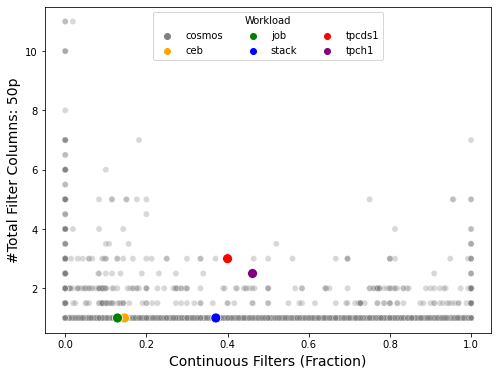

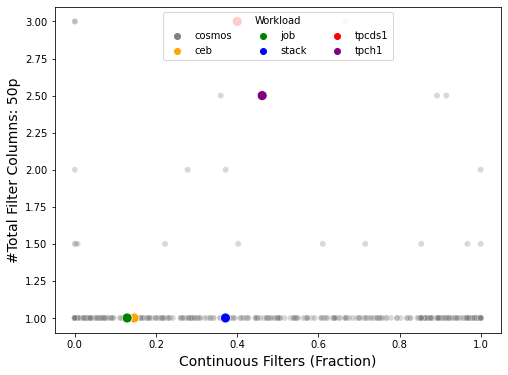

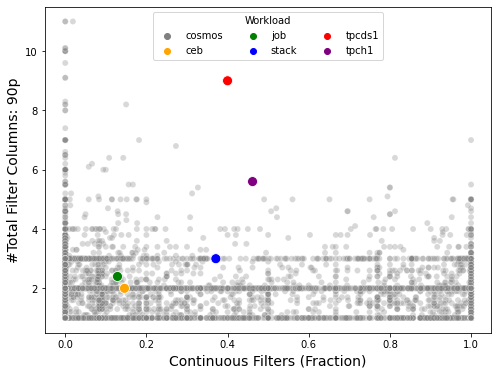

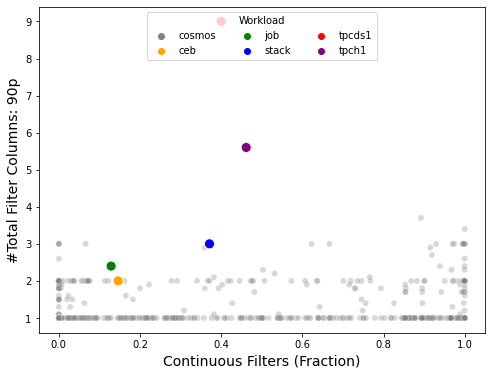

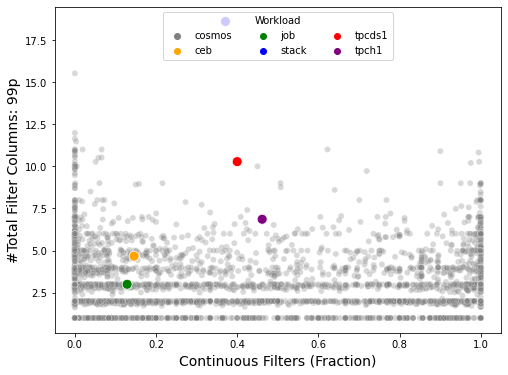

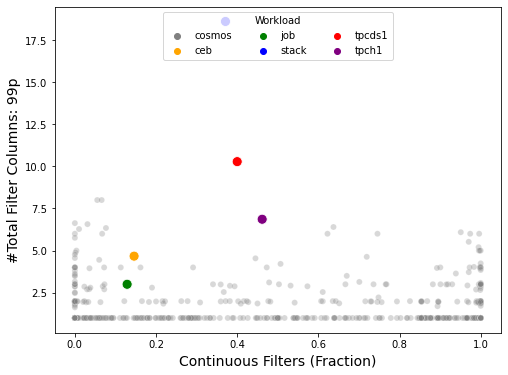

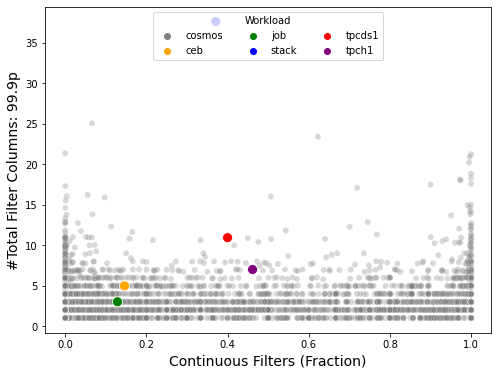

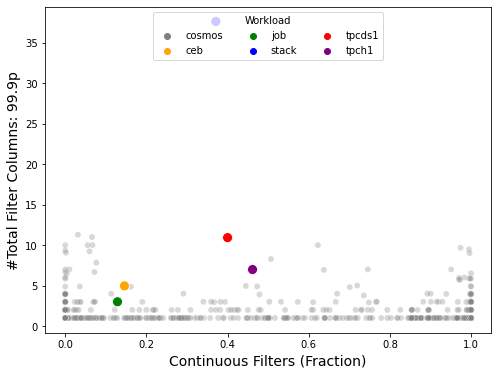

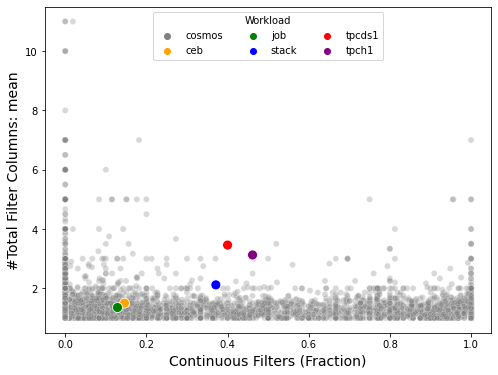

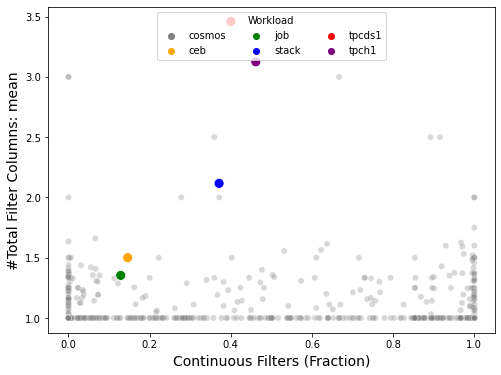

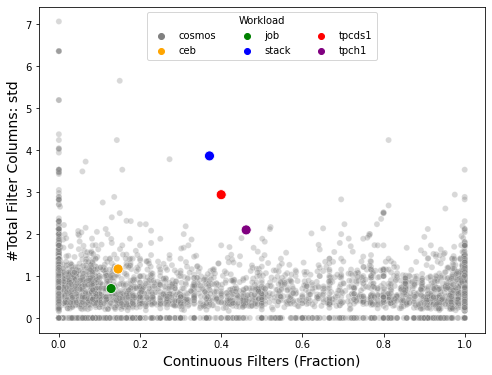

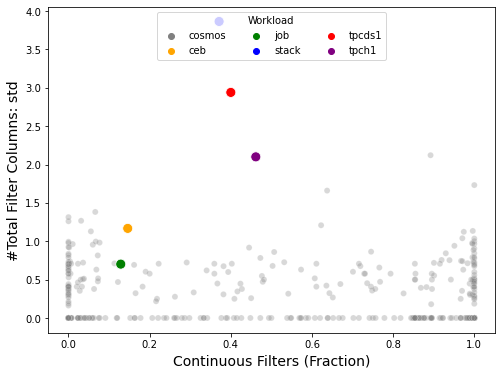

In [252]:
for p in PERCENTILES:
    plot_sel_fig(fcols, "cont_ops", p, "Continuous Filters (Fraction)", "#Total Filter Columns: " + p,
                prefix="IncludesSubqueries")
    plot_sel_fig(fcols1, "cont_ops", p, "Continuous Filters (Fraction)", "#Total Filter Columns: " + p,
            prefix="")

In [171]:
# seldf = exprdf[exprdf["RowCount"] != -1]
# seldf1 = exprdf1[exprdf1["RowCount"] != -1]
# #seldf.groupby(["cluster"])["Selectivity"].describe(percentiles=[0.25,0.75, 0.90, 0.95, 0.99])
# selps = seldf.groupby(["db", "workload", "cluster"])["Selectivity"].describe(percentiles=[0.5, 0.75, 0.9, 0.99, 0.999]).reset_index()
# selps = selps[selps.db.isin(seldbs)]
# #selps.head(5)

In [253]:
seldf = exprdf[exprdf["RowCount"] != -1]
seldf1 = exprdf1[exprdf1["RowCount"] != -1]

selps = seldf.groupby(["db", "workload", "cluster"])["Selectivity"].describe(percentiles=[0.5, 0.75, 0.9, 0.99, 0.999]).reset_index()
selps = selps[selps.db.isin(seldbs)]

selps1 = seldf1.groupby(["db", "workload", "cluster"])["Selectivity"].describe(percentiles=[0.5, 0.75, 0.9, 0.99, 0.999]).reset_index()
selps1 = selps1[selps1.db.isin(seldbs1)]


In [254]:
selps = selps.merge(udf, on=["db", "workload"], how="inner")
#selps.head(5)
selps1 = selps1.merge(udf1, on=["db", "workload"], how="inner")
selps.head(5)

,db,workload,cluster_x,count_x,mean_x,std_x,min_x,50%_x,75%_x,90%_x,99%_x,99.9%_x,max_x,count_y,mean_y,std_y,min_y,50%_y,75%_y,90%_y,99%_y,99.9%_y,max_y,cluster_y,cont_ops,discrete_ops,like_ops
0,ceb,ceb,ceb,21045.0,0.304178,0.349906,4.118765e-07,0.151789,0.428652,1.000000,1.000000,1.000000,1.000000,17796.0,1.047426,0.226382,1.0,1.0,1.0,1.0,2.00,3.000,3.0,ceb,0.145946,0.786426,0.072302
1,cosmos08-0310105,cosmos,cosmos08,154.0,0.125578,0.263083,0.000000e+00,0.022657,0.090144,0.314732,1.000000,1.000000,1.000000,74.0,1.797297,1.292547,1.0,1.0,2.0,4.0,5.00,5.000,5.0,cosmos08,0.220779,0.915584,0.000000
2,cosmos08-0310137,cosmos,cosmos08,31.0,1.000000,0.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.00,1.000,1.0,cosmos08,0.000000,1.000000,0.000000
3,cosmos08-0310139,cosmos,cosmos08,13.0,0.166079,0.143140,1.635485e-03,0.090453,0.298434,0.308346,0.360069,0.366354,0.367052,13.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.00,1.000,1.0,cosmos08,0.000000,0.461538,0.538462
4,cosmos08-0310156,cosmos,cosmos08,60.0,0.089051,0.071007,0.000000e+00,0.099719,0.102908,0.106539,0.286668,0.512519,0.537614,50.0,1.020000,0.141421,1.0,1.0,1.0,1.0,1.51,1.951,2.0,cosmos08,0.150000,0.900000,0.000000


In [ ]:
for p in PERCENTILES:
    plot_sel_fig(selps, p+"_y", p+"_x", "#Filter Columns: " + p, "Selectivity: " + p, 
                prefix="IncludesSubqueries")
    plot_sel_fig(selps1, p+"_y", p+"_x", "#Filter Columns: " + p, "Selectivity: " + p, 
            prefix="")

In [255]:
print(len(set(selps["db"])))

6297


In [ ]:
print(len(sel))